<a href="https://colab.research.google.com/github/MachineVisionTeam/Detectron2/blob/main/Detectron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15354, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 15354 (delta 27), reused 32 (delta 10), pack-reused 15275
Receiving objects: 100% (15354/15354), 6.23 MiB | 18.08 MiB/s, done.
Resolving deltas: 100% (11141/11141), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00
  

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt

In [ ]:

from detectron2.structures import BoxMode
def load_nucleus_dataset(img_dir, dataset_type):
    json_file = os.path.join(img_dir, f"nuc_coco_{dataset_type}.json")
    with open(json_file) as f:
        nucleus_data = json.load(f)
    category_name_to_id = {category["name"]: category["id"] for category in nucleus_data["categories"]}

    dataset_dicts = []
    for idx, img_info in enumerate(nucleus_data['images']):
        record = {}
        filename = os.path.join(img_dir, img_info['file_name'])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for ann in nucleus_data['annotations']:
            if ann['image_id'] == img_info['id']:
                segmentation = ann['segmentation']
                category_name = nucleus_data["categories"][ann["category_id"]]["name"]
                poly = []
                for seg in segmentation:
                    poly.extend(seg)
                objs.append({
                    "bbox": [np.min(poly[::2]), np.min(poly[1::2]), np.max(poly[::2]), np.max(poly[1::2])],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": category_name_to_id[category_name],
                })

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts
train_dataset = load_nucleus_dataset("/content/drive/MyDrive/Detectron/Detectron/nucleus/train", "train")
val_dataset = load_nucleus_dataset("/content/drive/MyDrive/Detectron/Detectron/nucleus/val", "val")
DatasetCatalog.register("nucleus_train", lambda: train_dataset)
DatasetCatalog.register("nucleus_val", lambda: val_dataset)
MetadataCatalog.get("nucleus_train").set(thing_classes=["tumor", "fibroblast", "lymphocyte", "plasma_cell", "macrophage", "mitotic_figure", "vascular_endothelium", "myoepithelium", "apoptotic_body", "neutrophil", "ductal_epithelium", "eosinophil", "unlabeled"])
MetadataCatalog.get("nucleus_val").set(thing_classes=["tumor", "fibroblast", "lymphocyte", "plasma_cell", "macrophage", "mitotic_figure", "vascular_endothelium", "myoepithelium", "apoptotic_body", "neutrophil", "ductal_epithelium", "eosinophil", "unlabeled"])
nucleus_metadata_train = MetadataCatalog.get("nucleus_train")
nucleus_metadata_val = MetadataCatalog.get("nucleus_val")



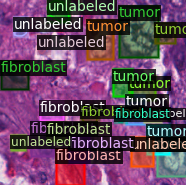

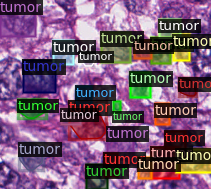

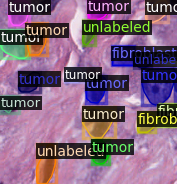

In [ ]:
dataset_dicts = load_nucleus_dataset("/content/drive/MyDrive/Detectron/Detectron/nucleus/train/","train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=nucleus_metadata_train, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/Detectron/Output"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("nucleus_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 100000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)


[02/04 17:22:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 251MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
trainer.train()

[02/03 19:58:13 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/03 19:58:26 d2.utils.events]:  eta: 0:07:19  iter: 19  total_loss: 6.485  loss_cls: 2.728  loss_box_reg: 0.6014  loss_mask: 0.6893  loss_rpn_cls: 2.317  loss_rpn_loc: 0.2009    time: 0.4836  last_time: 0.4631  data_time: 0.0174  last_data_time: 0.0074   lr: 4.9953e-06  max_mem: 1980M
[02/03 19:58:38 d2.utils.events]:  eta: 0:07:01  iter: 39  total_loss: 5.145  loss_cls: 2.611  loss_box_reg: 0.6611  loss_mask: 0.6873  loss_rpn_cls: 1.049  loss_rpn_loc: 0.184    time: 0.4594  last_time: 0.4066  data_time: 0.0112  last_data_time: 0.0017   lr: 9.9902e-06  max_mem: 1980M
[02/03 19:58:47 d2.utils.events]:  eta: 0:06:51  iter: 59  total_loss: 4.324  loss_cls: 2.457  loss_box_reg: 0.691  loss_mask: 0.6842  loss_rpn_cls: 0.3511  loss_rpn_loc: 0.1703    time: 0.4503  last_time: 0.4499  data_time: 0.0103  last_data_time: 0.0058   lr: 1.4985e-05  max_mem: 1980M
[02/03 19:58:56 d2.utils.events]:  eta: 0:06:41  iter: 79  total_loss: 3.97  loss_cls: 2.214  loss_box_reg: 0.6623  loss_mask: 0.6805 

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[02/04 17:22:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Detectron/Output/model_final.pth ...


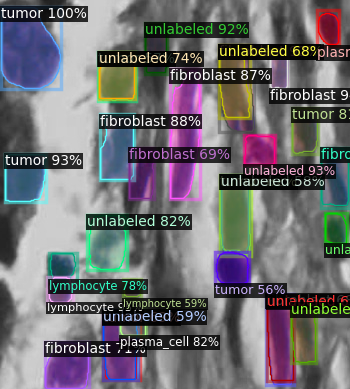

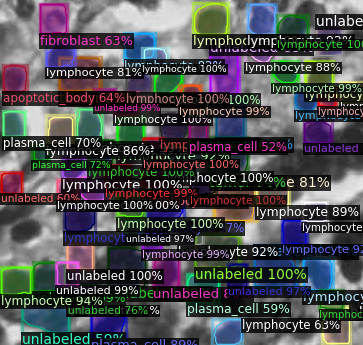

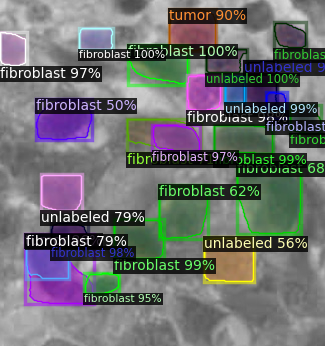

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = load_nucleus_dataset("/content/drive/MyDrive/Detectron/Detectron/nucleus/val","val")

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=nucleus_metadata_val,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("nucleus_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "nucleus_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[02/04 17:28:05 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[02/04 17:28:05 d2.evaluation.coco_evaluation]: Trying to convert 'nucleus_val' to COCO format ...
[02/04 17:28:05 d2.data.datasets.coco]: Converting annotations of dataset 'nucleus_val' to COCO format ...)
[02/04 17:28:05 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/04 17:28:05 d2.data.datasets.coco]: Conversion finished, #images: 4, #annotations: 179
[02/04 17:28:05 d2.data.datasets.coco]: Caching COCO format annotations at './output/nucleus_val_coco_format.json' ...
[02/04 17:28:05 d2.data.build]: Distribution of instances among all 13 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|     tumor     | 51           |  fibroblast   | 23           |  lymphocyte   | 65           |
|  plasma_cell  | 0 

In [ ]:
import json
import numpy as np
import cv2
import os
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from sklearn.metrics import accuracy_score
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x_intersect = max(x1, x2)
    y_intersect = max(y1, y2)
    w_intersect = max(0, min(x1 + w1, x2 + w2) - x_intersect)
    h_intersect = max(0, min(y1 + h1, y2 + h2) - y_intersect)
    area_intersect = w_intersect * h_intersect
    area_union = w1 * h1 + w2 * h2 - area_intersect
    iou = area_intersect / max(area_union, 1e-5)

    return iou
with open("/content/drive/MyDrive/Detectron/Detectron/nucleus/val/nuc_coco_val.json", "r") as f:
    annotations = json.load(f)


iou_scores = []
total_annotations = 0
correct_predictions = 0
gt_classes = []
pred_classes = []
for image_info in annotations['images']:
    image_path = os.path.join("/content/drive/MyDrive/Detectron/Detectron/nucleus/val", image_info["file_name"])
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        continue
    outputs = predictor(image)
    gt_bbox = None
    for annotation in annotations['annotations']:
        if annotation['image_id'] == image_info['id']:
            gt_bbox = annotation["bbox"]
            break
    if gt_bbox is None:
        print(f"No ground truth annotation found for image: {image_info['file_name']}")
        continue
    pred_bbox = outputs["instances"].pred_boxes.tensor.cpu().numpy()[0]
    iou = calculate_iou(gt_bbox, pred_bbox)
    print(f"IoU for image {image_info['file_name']}: {iou}")
    print("Ground Truth Bounding Box:", gt_bbox)
    print("Predicted Bounding Box:", pred_bbox)
    iou_scores.append(iou)
    print(f"IoU for image {image_info['file_name']}: {iou}")
    for annotation in annotations['annotations']:
        if annotation['image_id'] == image_info['id']:
            gt_class = annotation["category_id"]
            pred_class = outputs["instances"].pred_classes.cpu().numpy()[0]
            gt_classes.append(gt_class)
            pred_classes.append(pred_class)
accuracy = accuracy_score(gt_classes, pred_classes)
print("Accuracy:", accuracy)
mean_iou = np.mean(iou_scores)
print("Mean IoU:", mean_iou)

IoU for image TCGA-A1-A0SP-DX1.png: 0.0
Ground Truth Bounding Box: [232, 160, 65, 71]
Predicted Bounding Box: [ 78.81112   28.305298 112.68401   50.26939 ]
IoU for image TCGA-A1-A0SP-DX1.png: 0.0
IoU for image TCGA-AC-A2BK-DX1.png: 0.1943671863634232
Ground Truth Bounding Box: [96, 32, 47, 72]
Predicted Bounding Box: [101.91991   32.501255 142.36887  103.00462 ]
IoU for image TCGA-AC-A2BK-DX1.png: 0.1943671863634232
IoU for image TCGA-BH-A0AV-DX1.png: 0.0
Ground Truth Bounding Box: [0, 302, 55, 20]
Predicted Bounding Box: [294.73407  86.28456 317.40485 110.86073]
IoU for image TCGA-BH-A0AV-DX1.png: 0.0
IoU for image TCGA-BH-A0BL-DX1.png: 0.0
Ground Truth Bounding Box: [289, 109, 30, 38]
Predicted Bounding Box: [ 0.8074317  7.257577  60.567566  89.22992  ]
IoU for image TCGA-BH-A0BL-DX1.png: 0.0
Accuracy: 0.48044692737430167
Mean IoU: 0.0485917965908558
